# Computational Social Science Project #2 

**Enter your Name:**Cindy Alvarez

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [236]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# use magic function
%matplotlib inline


# set style
sns.set_style("darkgrid")

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [237]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [238]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [239]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [240]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [241]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 


['No Data']


In [242]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique()) 


['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [243]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!='Suppressed'] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype('int64') 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!='No Data']

# converting obesity to an integer

diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype('int64')

# Physical Inactivity
# ----------

diabetes = diabetes[diabetes['Physical_Inactivity_Number']!='No data']

# converting inactivity to an integer

diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype('int64')

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype('float64')

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [244]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [245]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [246]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'hispanic or latino and race_total population',
 'race_total population_one race_1',
 'sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1']

In [247]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns= ['sex and age_total population',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1',
 'hispanic or latino and race_total population',
 'race_total population_one race_1',
 'sex and age_total population_65 years and over_1']) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [248]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

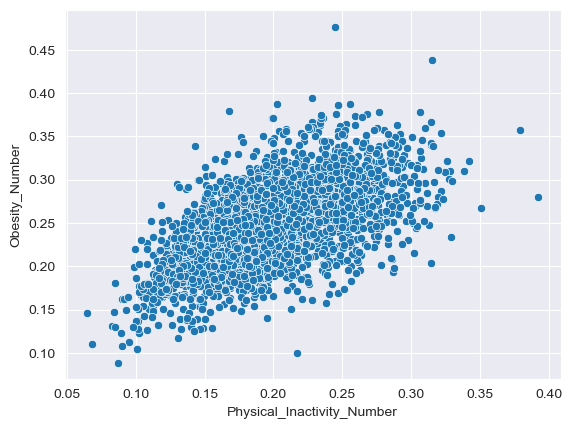

In [249]:
#
# EDA #1: Exploring the relationship between physical inactivity and obesity. This scatterplot demonstrates the positive and seemingly linear 
# relationship between rates of physical inactivity per county and obesity rates per county. While unsurprising, the stark positive relationship
# reinforces the idea that physical activity is strongly associated with obesity. It is also important to understand the relationship between obesity
# and diabetes. 
#-----------

sns.scatterplot(x = "Physical_Inactivity_Number",
                y = "Obesity_Number",
                data = diabetes);


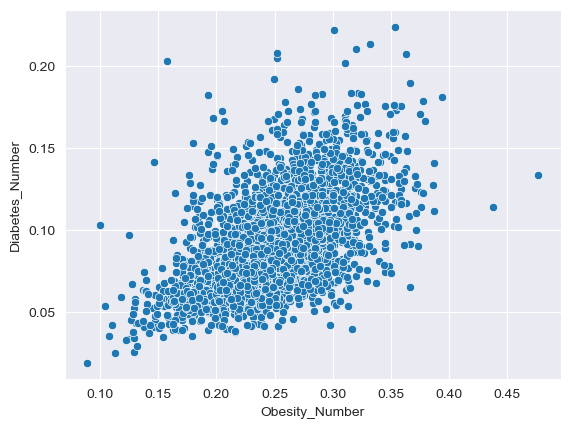

In [250]:
#
# EDA #2 Exploring the relationship bewtween obesity and diabetes rates. This scatterplot demonstrates the strong, positive relationship between 
# the rates of obesity and the rates of diabetes by county. This illustrates that obesity could be a strong predictor of diabetes in our model.  
#-----------

sns.scatterplot(x = "Obesity_Number",
                y = "Diabetes_Number",
                data = diabetes);


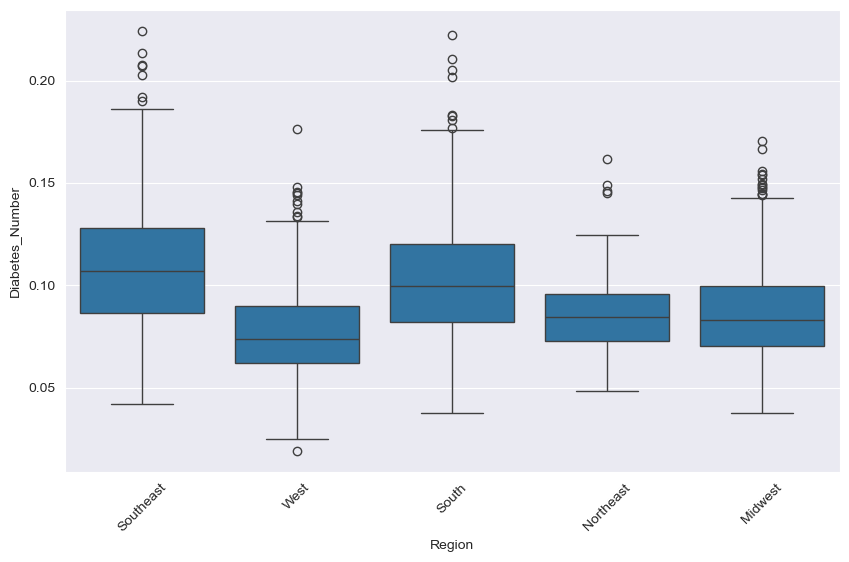

In [251]:
#
# EDA #3 These box plots demonstrate the relationship between the rate of diabetes and regions in the United States. Qualitatively, it seems that rates 
# of diabetes are higher in the Southeast and the South than they are in the West, Northeast, and Midwest. Region might be a good predictor of diabetes.
# Given our scatterplots above, we might expect to see higher rates of physical inactivity and obesity in the South and Southeast as well.
# ----------

plt.figure(figsize=(10, 6))

sns.boxplot(data=diabetes, 
            x="Region", 
            y="Diabetes_Number")
plt.xticks(rotation=45)
plt.show()


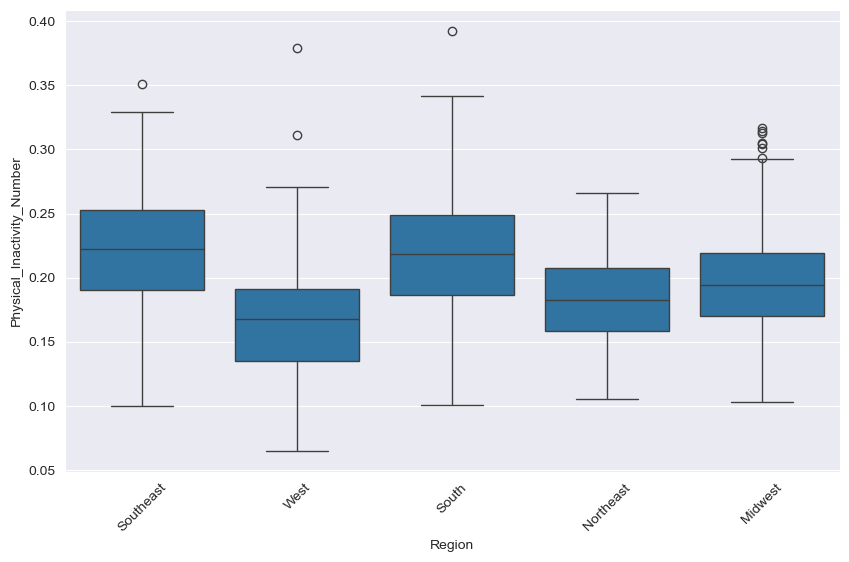

In [252]:
#
# EDA #4 These box plots demonstrate the relationship between the rate of of physical inactivity and regions in the United States. It seems that 
# rates of physical inactivity are also higher in the Southeast and the South than they are in the West, Northeast, and Midwest. This supports the 
# findings from our scatterplots above as physical inactivity was positively associated with obesity which was positively associated with diabetes. 
# It makes sense that regions with higher rates of diabetes also have higher rates of physical inactivity.
# ----------

plt.figure(figsize=(10, 6))

sns.boxplot(data=diabetes, 
            x="Region", 
            y="Physical_Inactivity_Number")
plt.xticks(rotation=45)
plt.show()

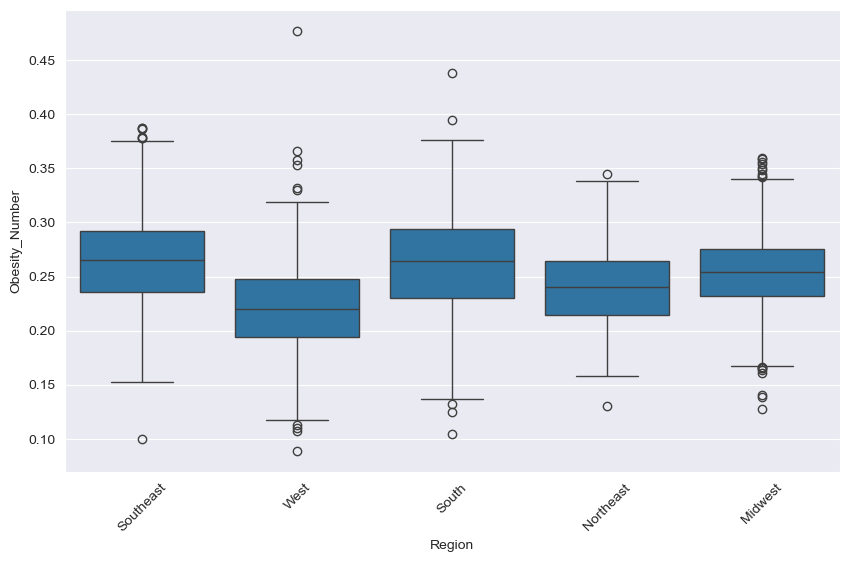

In [253]:
#
# EDA #5 Finally, these box plots demonstrate the relationship between rates of of obesity and regions in the United States. Unsurprisingly, these boxplots 
# mirror the boxplots above, showing that rates of obesity are also higher in the Southeast and the South than they are in the West, Northeast, 
# and Midwest. 
# ----------

plt.figure(figsize=(10, 6))

sns.boxplot(data=diabetes, 
            x="Region", 
            y="Obesity_Number")
plt.xticks(rotation=45)
plt.show()

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [254]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(data=diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [255]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number', 'race alone or in combination with one or more other races_total population'],
                 axis = 1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [256]:
#
# Feature selection
# Below, I am removing the feature: "hispanic or latino and race_total population_not hispanic or latino" because it is the perfect inverse of another
# feature that is already included in the dataset: "hispanic or latino and race_total population_hispanic or latino (of any race)". As such, we do not 
# need to include both because they would be perfectly colinear. I am also dropping the feature: "sex and age_total population_median age (years)" 
# because the features that describe the different proportions of people at different age ranges captures this information (e.g., sex and age_total 
# population_under 18 years", etc.) We also previously divided this feature by the total population, which does not make sense - I think if we wanted 
# to keep it, we would need to convert it back to the median age. But as this information is capture by the many other age features, it is fine to 
# remove.
#-----------

X = X.drop(['hispanic or latino and race_total population_not hispanic or latino',
            'sex and age_total population_median age (years)'],
          axis = 1)


In [257]:
# Checking for highly correlated features

correlation_matrix = X.corr()
high_corr_pairs = np.where(np.abs(correlation_matrix) > 0.9)  # Threshold of 0.9
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                   for x, y in zip(*high_corr_pairs) if x != y]

# Print highly correlated pairs
for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1} & {feat2}: {corr:.3f}")

race_total population_one race & race_total population_two or more races: -1.000
race_total population_one race & hispanic or latino and race_total population_not hispanic or latino_two or more races: -0.951
race_total population_one race & hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races: -0.948
race_total population_two or more races & race_total population_one race: -1.000
race_total population_two or more races & hispanic or latino and race_total population_not hispanic or latino_two or more races: 0.951
race_total population_two or more races & hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races: 0.948
race_total population_one race_white & race alone or in combination with one or more other races_total population_white: 0.995
race_total population_one race_black or african american & ra

In [258]:
print(f"Original shape: {X.shape}")

Original shape: (3112, 87)


In [259]:
# The above output shows that there are several groups of highly correlated features that we should simplify: 1) Sex and age statistics, and 2) Race 
# statistics. As such we will remove redundant features:
# ----------

# For sex and age features
features_to_drop = [
    'sex and age_total population_female',  # Keep male, drop female (perfectly correlated)
    'sex and age_total population_16 years and over',  # Keep 18 years and over
    'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  # Keep total sex ratio
    'sex and age_total population_62 years and over',  # Keep 65 and over
    'sex and age_total population_65 years and over_male',  # Keep total 65+
    'sex and age_total population_65 years and over_female'  # Keep total 65+
]

# For race features
features_to_drop.extend([
    'race_total population_two or more races',  # Keep one race, drop two or more (perfectly correlated)
    'race alone or in combination with one or more other races_total population_white',  # Keep one race versions
    'race alone or in combination with one or more other races_total population_black or african american',
    'race alone or in combination with one or more other races_total population_asian',
    'race alone or in combination with one or more other races_total population_american indian and alaska native',
    'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander',
    'race alone or in combination with one or more other races_total population_some other race',
    'hispanic or latino and race_total population_not hispanic or latino_black or african american alone',  # Keep one race versions
    'hispanic or latino and race_total population_not hispanic or latino_asian alone',
    'hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone',
    'hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone'
])

# Print original shape
print(f"Original shape: {X.shape}")

# Drop features in place
X.drop(columns=features_to_drop, inplace=True)

# Print new shape
print(f"New shape: {X.shape}")

Original shape: (3112, 87)
New shape: (3112, 70)



Feature Importance Ranking:
                                              feature    importance
1                                      Obesity_Number  8.250002e-03
68                                   Region_Southeast  7.860860e-03
2                          Physical_Inactivity_Number  7.282615e-03
67                                       Region_South  7.053809e-03
28  race_total population_two or more races_white ...  4.850833e-03
66                                   Region_Northeast  3.800537e-03
5                      race_total population_one race  3.768781e-03
6                race_total population_one race_white  3.699379e-03
7   race_total population_one race_black or africa...  3.491069e-03
29  race_total population_two or more races_white ...  3.361056e-03
57        sex and age_total population_65 to 74 years  3.326278e-03
69                                        Region_West  3.053523e-03
51        sex and age_total population_20 to 24 years  2.364324e-03
43  citizen -  voti

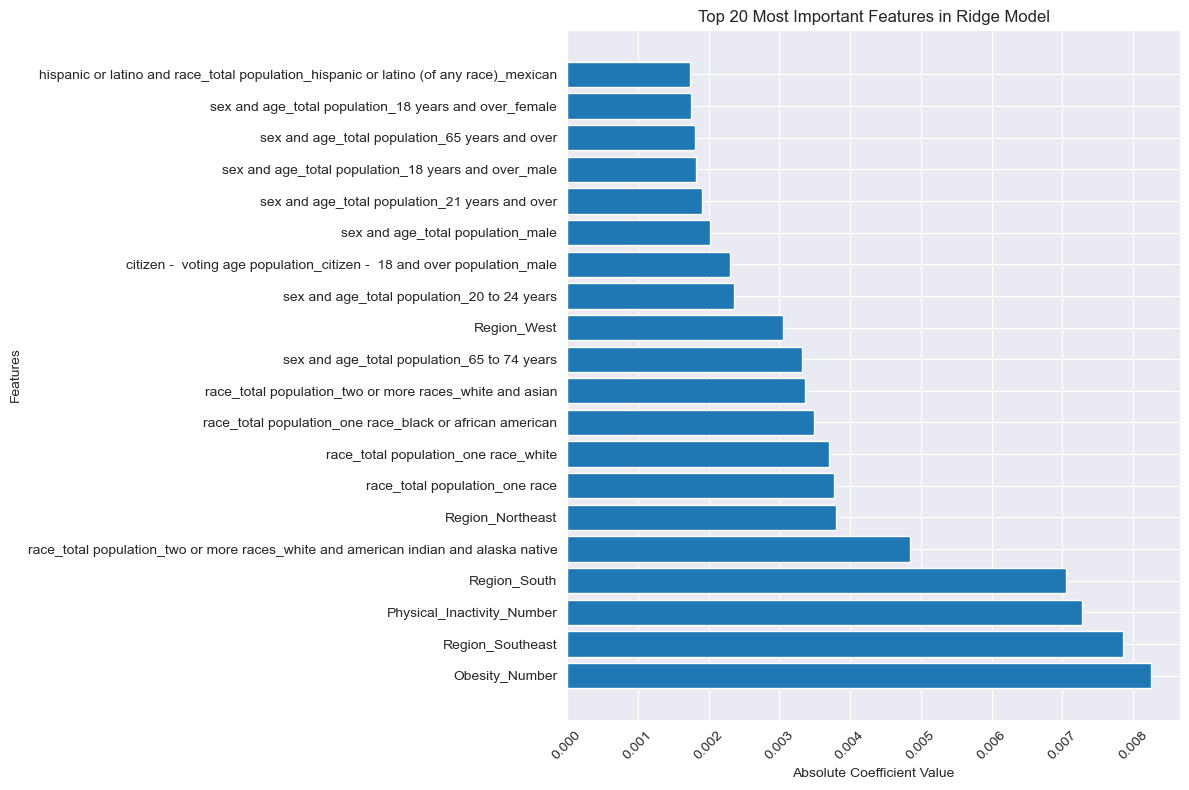


Top 20 Most Important Features:
                                                                                  feature  importance
1                                                                          Obesity_Number    0.008250
68                                                                       Region_Southeast    0.007861
2                                                              Physical_Inactivity_Number    0.007283
67                                                                           Region_South    0.007054
28    race_total population_two or more races_white and american indian and alaska native    0.004851
66                                                                       Region_Northeast    0.003801
5                                                          race_total population_one race    0.003769
6                                                    race_total population_one race_white    0.003699
7                                race_total popul

In [260]:
# Get feature importance based on absolute coefficient values
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(ridge_model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Display the full ranked list
print("\nFeature Importance Ranking:")
print(feature_importance)

# Create visualization of top 20 features
plt.figure(figsize=(12, 8))
top_n = 20
plt.barh(feature_importance['feature'][:top_n], 
         feature_importance['importance'][:top_n])
plt.title('Top 20 Most Important Features in Ridge Model')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print top 20 features with their importance values
print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string())

In [261]:
# Given teh above list and chart, we definitely want to keep the following features: "Obseity_Number" and "Physical_Inactivity_NUmber" as well as 
# regional indicators. To streamline our models, we will drop features below a certain importance threshold:
# ------

# Convert feature importance to a DataFrame if it's not already
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(ridge_model.coef_)
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Set a threshold (you can adjust this value)
threshold = 0.001  # This will keep features with importance > 0.001

# Get list of features to keep
features_to_keep = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()

# Print info about feature reduction before dropping
print("Original shape of X:", X.shape)

# Store dropped features for display
dropped_features = feature_importance[feature_importance['importance'] <= threshold]

# Update X in place by dropping low importance features
X.drop(columns=X.columns.difference(features_to_keep), inplace=True)

# Print new shape and feature reduction info
print("New shape of X:", X.shape)
print(f"Number of features dropped: {len(dropped_features)}")

print("\nDropped features:")
print(dropped_features.to_string())


Original shape of X: (3112, 70)
New shape of X: (3112, 32)
Number of features dropped: 38

Dropped features:
                                                                                                                                                 feature    importance
33                                                            hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican  9.934269e-04
40  hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races  9.507605e-04
38                                                                 hispanic or latino and race_total population_not hispanic or latino_two or more races  9.386520e-04
35                                                hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino  9.338411e-04
41                                                      

In [262]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [263]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,
                                                             y_train,
                                                             train_size=0.75,
                                                             test_size=0.25)

In [264]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** ...

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  Linear regression (Ordinary Least Squares) 

In [265]:
#
# Model 1 training
#-----------

# creating and fitting the linear model
lin_reg = LinearRegression()

lin_model = lin_reg.fit(X_train, y_train)

#### Model 2:  Ridge Regression

In [266]:
#
# Model 2 training
#-----------

# Creating and fitting a Ridge regression model
ridge_reg = Ridge()                                              
ridge_model = ridge_reg.fit(X_train, y_train)                    


#### Model 3:  LASSO Regression

In [267]:
#
# Model 3 training
#-----------
# Creating and fitting a LASSO regression model
lasso_reg = Lasso(alpha=0.001, max_iter=15000)  
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [120]:
#### Model 1:  Linear Regression

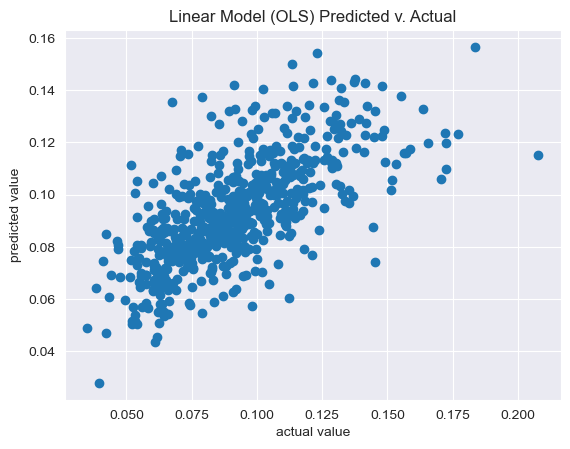

In [268]:
#
#-----------
# Evaluate how good the linear model is by assessing the difference between the predicted values and the actual values (e.g., the error).
# We will use the validation dataset and the trained model, and predict the rate of diabetes. 
#-----------
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
#-----------
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

In [122]:
# TO UPDATE The above scatter plot shows that that the X-axis (actual value) shows true diabetes rates ranging from about 0.05 to .20.
# The Y-axis (predicted value) shows the model's predictions ranging similarly. 
# The  points roughly follow a diagonal trend, which is good as it means predictions correlate with actual values
# However, there's considerable scatter/spread around this trend, indicating imperfect predictions.

In [269]:
# To get a quantitative value for how well our linear model is predicting diabetes rates, we will calcualte the root mean squared error.
# Create function to calculate the root mean squared error
#-----------

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [270]:
# Calculate the root mean squared error

rmse(lin_pred,    # specify the predicted values
     y_validate)  # specify the actual values

0.019341055125365766

In [125]:
# The RMSE of 0.019 means that on average, the model's predictions deviate from the true values by about 0.019. This aligns 
# with what we see in the scatter plot. Given that diabetes rates in the data range from ~5% to 20%, an error of 1.9 percentage points is relatively
# significant but not terrible. Below I tune the hyperparameters and rerun the model to see if we can improve it.

In [271]:
#
# Linear regression tuning
#-----------

# specify the hyperparameters
param_grid = {'fit_intercept': [True, False]}          

# execute the grid search
lin_grid_reg = GridSearchCV(estimator  = lin_reg,      # model to be tuned
                            param_grid = param_grid,   # parameters to be searched as specified above
                            cv=3)                      # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lin_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset
best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)     # find best estimator and predict on validate

# print the results  
print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lin_pred, y_validate))

{'fit_intercept': True}
Best CV R^2: 0.5090656865422225
Validation R^2: 0.4477271264498075
Validation RMSE 0.019341055125365766


In [127]:
# [TO UPDATE] After executing a grid search to identify the best performing model, it looks like the R-squared is 0.486, which is a bit low.
# The Validation R2 is even lower at 0.452, which suggests that the model might be overfitting and isn't generalizing well to new data. Its performance
# is worse on data it hasn't seen before. The validation RMSE of 0.0193 means predictions are off by about 1.93 percentage points on average.

In [128]:
#### Model 2:  Ridge Regression

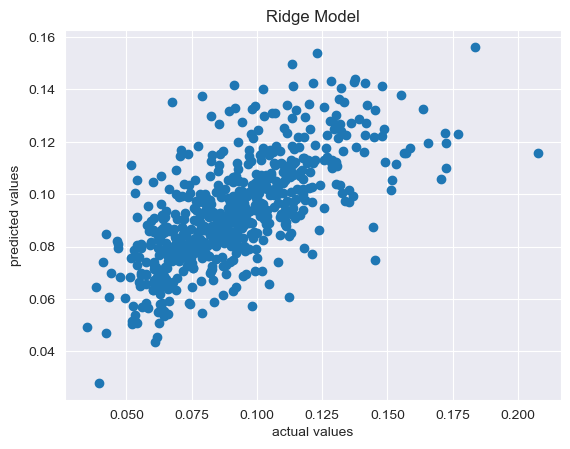

In [272]:
# Using the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [130]:
# [TO UPDATE] # The above scatter plot shows a similar positive correlation between predicted and actual values as the linear model and the range of values is the
# same. This scatter plot seems to have slightly less extreme predictions as the predicted values seem more compressed toward the middle range (around 
# 0.08-0.12). There are fewer very high or very low predictions compared to OLS, which is expected as Ridge adds regularizaation to prevent overfitting.

In [273]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_validate)

0.019328449572678423

In [132]:
# [TO UPDATE] The RMSE for Ridge (0.1924) is slightly better than OLS (0.0215).This suggests that the Ridge regression's regularization is helping to create 
# a more robust model with slightly better predictive performance than the OLS. Below I tune the hyperparameters and rerun the model to see if we can 
# improve it.

In [274]:
# We will run 9*2*4 = 72 tests, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.array([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

{'alpha': 10.0, 'fit_intercept': True, 'solver': 'lsqr'}
Best CV R^2: 0.5113447945231662
Validation R^2: 0.4513022752551309
Validation RMSE 0.019278351140187826


In [134]:
# [TO UPDATE] After executing a grid search to identify the best performing Ridge model, it looks like the Best CV R-squared is 0.47996, which is only a bit higher 
# than the OLS model. The Validation R2 (0.4282), however, is approximately 11 percentage points higher than the OLS validation R2 (0.318), which 
# suggests that the Ridge model is generalizing better to new data. However, its performance is still worse on data it hasn't seen before than with 
# training data. The validation RMSE of 0.01967 is also an improvement on the OLS validation RMSE (0.0215), which means its predictions are more 
# accurate than the OLS predictions by about 0.2 percentage points on average. 

In [135]:
#### Model 3:  LASSO Regression

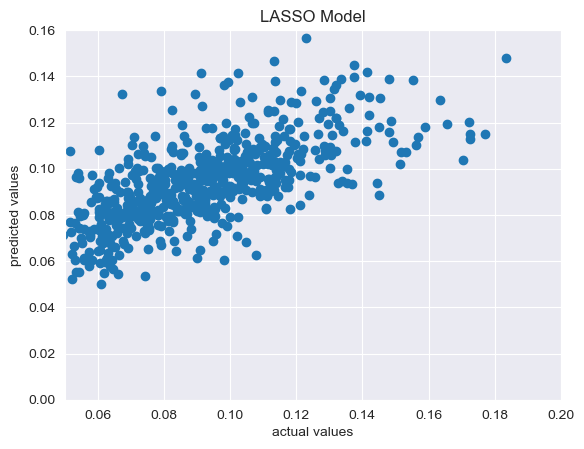

In [275]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')

# Set y-axis limits to match other plots (0 to 0.16) to facilitate comparison.
plt.ylim(0, 0.16)
# Set x-axis limits to match other plots (0.05 to 0.20) to facilitate comparison.
plt.xlim(0.05, 0.20)

plt.show()

In [137]:
 # The above scatterplot shows how the LASSO model's predictions are similar to the previous two models but it seems to slightly underpredict at higher 
# actual values. There is also more variance in the predictions when actual values are higher.

In [276]:
# Calculate the rmse for the LASSO model
rmse(lasso_pred, y_validate)

0.019278921599445442

In [139]:
# This model's RMSE is slightly lower than the Ridge model's RMSE, suggesting it's performing slightly better than both Ridge and OLS. This makes sense
# because LASSO provides a balance of regularization and is avoiding the overfit tendency of OLS, and is less aggressive in shrinking coefficients 
# compares to Ridge (seen in the less compressed predictions). 

In [277]:
# specify the hyperparameters
param_grid = {'alpha': np.array([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])   # find the best performing model
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)    # find best estimator and predict on validate

# print results
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

{'alpha': 0.0001, 'fit_intercept': True, 'selection': 'random'}
Best CV R^2: 0.5083374006176539
Validation R^2: 0.4575636083346466
Validation RMSE 0.019168040390482748


In [ ]:
# TO UPDATE After adjusting the alpha for the LASSO model gridsearch to range from 0.0001-10, we find that the best CV R2 is 0.4995. The validation R2 is 0.459 

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [87]:
# TO UPDATE
# Predict using your best model
#-----------
# The best performing model was the Ridge model. To select out unimportant features, we must review the coefficients:

# Get coefficients from your best Ridge model
coef = ridge_grid_reg.best_estimator_.coef_

# Get feature names 
feature_names = X_train.columns  

# Create a DataFrame of features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': abs(coef)  # Take absolute value to measure magnitude of importance
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

# Print all features and their coefficients
print("Feature coefficients (absolute values):")
print(feature_importance)



Feature coefficients (absolute values):
                                              Feature   Coefficient
35  race alone or in combination with one or more ...  1.695067e-02
82  sex and age_total population_65 years and over...  1.048216e-02
1                                      Obesity_Number  8.304732e-03
81  sex and age_total population_65 years and over...  8.229564e-03
46  hispanic or latino and race_total population_n...  7.374075e-03
85                                   Region_Southeast  7.355994e-03
2                          Physical_Inactivity_Number  7.198544e-03
84                                       Region_South  6.792711e-03
29  race_total population_two or more races_white ...  5.905811e-03
27     race_total population_one race_some other race  5.568002e-03
7                race_total population_one race_white  5.453735e-03
14               race_total population_one race_asian  5.382103e-03
16       race_total population_one race_asian_chinese  5.261060e-03
73     s

In [88]:
# TO UPDATE Based on the coefficients in the output, it looks like there are a few breaking points in the values. Features below around 3.0e-03 seem to have
# relatively small impactso we will set a threshold at 3.0-03 or 0.003.
# Setting threshold of 0.003

threshold = 3.0e-03  # or 0.003
important_features = feature_importance[feature_importance['Coefficient'] > threshold]

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [ ]:
#
# Run cross-validation
#-----------



## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**YOUR ANSWER HERE**...

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**...

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**...